In [2]:
from textwrap import wrap

import emoji
import joblib
import langdetect
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier

plt.style.use("fivethirtyeight")
warnings.filterwarnings("ignore")

In [3]:
# library yg dibutuhkan 
# pip install emoji
# pip install langdetect

# Data Loading

Untuk <b>trending.csv</b> kita bisa langsung membaca data tersebut menggunakan <b>pandas</b>. Khusus untuk <b>category.json</b>, kita akan definisikan fungsi berikut untuk membantu kita membaca data kategori video.

In [4]:
def get_category_dict(category_file):
    category = pd.read_json(category_file, orient="records")
    category = pd.DataFrame(category["items"].values.tolist())

    return {
        cat.id: cat.snippet.get("title")
        for cat in category.itertuples(index=False)
    }

In [5]:
def get_category_dict(category_file):
    category = pd.read_json(category_file, orient="records")
    category = pd.DataFrame(category["items"].values.tolist())

    return {
        cat.id: cat.snippet.get("title")
        for cat in category.itertuples(index=False)
    }

In [6]:
category_dict = get_category_dict("D:/PTA 2016-2017/Modul/dataset/category.json")

In [7]:
trending = pd.read_csv("D:/PTA 2016-2017/Modul/dataset/trending.csv", parse_dates=["publish_time", "trending_time"])

with pd.option_context("display.max_columns", None):
    display(trending.head())

,video_id,publish_time,channel_id,title,description,thumbnail_url,thumbnail_width,thumbnail_height,channel_name,tags,category_id,live_status,local_title,local_description,duration,dimension,definition,caption,license_status,allowed_region,blocked_region,view,like,dislike,favorite,comment,trending_time
0,NaN,2021-02-05 09:00:34+00:00,UCEf_Bc-KVd7onSeifS3py9g,aespa 에스파 'Forever (약속)' MV,"aespa's new single ""Forever"" is out!\nListen a...",NaN,NaN,NaN,SMTOWN,NaN,10,none,aespa 에스파 'Forever (약속)' MV,"aespa's new single ""Forever"" is out!\nListen a...",PT5M7S,2d,hd,True,True,NaN,NaN,7806846.0,857902.0,24078.0,0,94961.0,2021-02-07 05:46:51.832614+00:00
1,NaN,2021-02-04 15:54:08+00:00,UCYEa4_MC7OFjcWrO6SO-u8g,[FULL] Siapa di Balik Kudeta AHY? | Dua Sisi t...,"Jakarta, https://www.tvonenews.com - Ketua umu...",NaN,NaN,NaN,Indonesia Lawyers Club,"['tvone', 'tv one', 'tvonenews', 'indonesia la...",25,none,[FULL] Siapa di Balik Kudeta AHY? | Dua Sisi t...,"Jakarta, https://www.tvonenews.com - Ketua umu...",PT42M30S,2d,hd,False,True,NaN,NaN,885038.0,6765.0,1263.0,0,6365.0,2021-02-07 05:46:51.832649+00:00
2,NaN,2021-02-06 03:00:22+00:00,UCu12RxQjRQyh79YBYvEDkOg,CABRIOLET CHALLENGE: TANTANGAN MENGGODA (7/12),Road Party Season 2: Cabriolet Challenge\n\nEp...,NaN,NaN,NaN,Motomobi,"['MotoMobi', 'Mobil', 'motor', 'review', 'indo...",2,none,CABRIOLET CHALLENGE: TANTANGAN MENGGODA (7/12),Road Party Season 2: Cabriolet Challenge\n\nEp...,PT46M43S,2d,hd,False,True,NaN,NaN,889708.0,47895.0,532.0,0,8785.0,2021-02-07 05:46:51.832664+00:00
3,NaN,2021-02-05 20:26:08+00:00,UCCuzDCoI3EUOo_nhCj4noSw,With Windah Basudara & Hans,Join this channel to get access to perks:\nhtt...,NaN,NaN,NaN,yb,NaN,20,none,With Windah Basudara & Hans,Join this channel to get access to perks:\nhtt...,PT45M59S,2d,hd,False,True,NaN,NaN,1006854.0,91973.0,3967.0,0,12957.0,2021-02-07 05:46:51.832678+00:00
4,NaN,2021-02-03 23:14:54+00:00,UC14UlmYlSNiQCBe9Eookf_A,🤯 LATE COMEBACK DRAMA! | HIGHLIGHTS | Granada ...,"With just two minutes to play, Barça looked to...",NaN,NaN,NaN,FC Barcelona,"['FC Barcelona', 'برشلونة،', 'Fútbol', 'FUTBOL...",17,none,🤯 LATE COMEBACK DRAMA! | HIGHLIGHTS | Granada ...,"With just two minutes to play, Barça looked to...",PT5M12S,2d,hd,False,True,NaN,NaN,6275035.0,218131.0,4289.0,0,12799.0,2021-02-07 05:46:51.832730+00:00


In [8]:
start_date = trending.trending_time.min()
end_date = trending.trending_time.max()

print(f"{start_date = }")
print(f"{end_date = }")

start_date = Timestamp('2021-02-07 05:46:51.832614+0000', tz='UTC')
end_date = Timestamp('2022-01-05 06:01:25.924242+0000', tz='UTC')


Bisa kita lihat bahwa data video trending dimulai dari bulan <b>Februari</b> sampai <b>Desember</b>. Untuk itu, kita akan drop data dari bulan <b>Februai sampai Juni</b>

In [9]:
filtered_trending = trending[trending.trending_time.dt.month >= 7]

start_date = filtered_trending.trending_time.min()
end_date = filtered_trending.trending_time.max()

print(f"{start_date = }")
print(f"{end_date = }")

start_date = Timestamp('2021-07-01 06:01:25.524449+0000', tz='UTC')
end_date = Timestamp('2021-12-31 06:01:10.612541+0000', tz='UTC')


In [10]:
num_videos = filtered_trending.shape[0]
print(f"{num_videos = }")

num_videos = 36337


Terdapat $36.337$ video yang masuk daftar trending setiap harinya dari bulan Juli sampai Desember. Selanjutnya, kita akan lakukan eksplorasi data terlebih dahulu sebelum mulai membuat model machine learning.

Selanjutnya, mari kita lihat bagaimana distribusi missing value pada masing-masing kolom.

In [11]:
# Distribusi Missing Value

filtered_trending.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 36337 entries, 21322 to 57658
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   video_id           4537 non-null   object             
 1   publish_time       36337 non-null  datetime64[ns, UTC]
 2   channel_id         36337 non-null  object             
 3   title              36337 non-null  object             
 4   description        34624 non-null  object             
 5   thumbnail_url      4537 non-null   object             
 6   thumbnail_width    4537 non-null   float64            
 7   thumbnail_height   4537 non-null   float64            
 8   channel_name       36337 non-null  object             
 9   tags               31487 non-null  object             
 10  category_id        36337 non-null  int64              
 11  live_status        36337 non-null  object             
 12  local_title        36337 non-null  object 

Dari informasi di atas, ada beberapa video yang kolom deskripsinya kosong. Untuk alasan modeling nanti, kita akan hapus video yang tidak memiliki teks deskripsi.

In [12]:
# Delete video dengan description kosong

filtered_trending.dropna(subset=["description"], inplace=True)

# Exploratory Data Analysis

Pertama, karena setiap hari, bahkan setiap beberapa jam, daftar trending di YouTube selalu ada pembaruan, mari kita lihat jumlah video dari hari per hari. Langkah-langkahnya yaitu:
<ul>
<li>Kelompokkan data berdasarkan tanggal per hari</li>

<li>Hitung jumlah video pada tanggal tersebut</li>
    </ul>

In [13]:
trending_by_date = filtered_trending.groupby(
    filtered_trending.trending_time.dt.date
)
num_trending_per_day = trending_by_date.trending_time.count()
print("Number of videos in trending per day:", num_trending_per_day.unique())

Number of videos in trending per day: [195 196 197 198 194 193 192 191 190 188 187 185 189 186 184 183 132 182
 181 179]


Jadi, setiap harinya, <u>+</u> 190 video yang masuk dalam daftar trending YouTube dari tanggal 1 Juli sampai 31 Desember.

# Trending Duration

Video masuk trending YouTube kadang kala juga bisa bertahan beberapa hari. Lama bertahannya video dalam daftar trending ini mungkin disebabkan oleh beberapa faktor seperti jumlah like, jumlah view, kecepatan kenaikan kedua metrik tersebut, dan lainnya. Mari kita lihat berapa lama durasi suatu video bertahan dalam trending YouTube.

In [14]:
trending_duration = filtered_trending.groupby("title").agg(
    trending_duration=pd.NamedAgg(column="trending_time", aggfunc="count"),
    trending_start_date=pd.NamedAgg(column="trending_time", aggfunc="min"),
    trending_last_date=pd.NamedAgg(column="trending_time", aggfunc="max")
).sort_values("trending_duration", ascending=False).reset_index()

trending_duration.head(10)

,title,trending_duration,trending_start_date,trending_last_date
0,Måneskin - Beggin' (Lyrics),30,2021-07-09 06:03:40.293908+00:00,2021-09-29 06:00:48.508222+00:00
1,Måneskin - Beggin' (Lyrics/Testo),30,2021-07-06 06:01:08.609842+00:00,2021-08-14 06:01:09.572758+00:00
2,"The Kid LAROI, Justin Bieber - Stay (Lyrics)",22,2021-08-07 06:00:58.727254+00:00,2021-11-02 06:00:52.042819+00:00
3,Happy Asmara - Lemah Teles (Official Music Liv...,21,2021-07-19 06:02:49.428626+00:00,2021-08-08 06:01:02.782146+00:00
4,WONDERLAND INDONESIA by Alffy Rev (ft. Novia B...,21,2021-08-18 06:00:55.039010+00:00,2021-09-07 06:00:48.332429+00:00
5,SAYA DI HANCURKAN DIA FISIK DAN MENTAL‼️ Edele...,21,2021-12-08 16:37:33.715522+00:00,2021-12-28 06:01:16.422183+00:00
6,"MERINDING GUE DENGER INI, GOKIL‼️ SEREM ABIS‼️...",20,2021-07-02 06:01:02.071087+00:00,2021-07-21 06:01:23.252876+00:00
7,Create your own short to Shivers using #Sheera...,20,2021-10-26 06:00:53.187313+00:00,2021-11-14 06:01:05.587878+00:00
8,Join the BTS #PermissiontoDance Challenge only...,20,2021-08-07 06:00:58.726624+00:00,2021-08-26 06:00:52.511071+00:00
9,BTS (방탄소년단) 'Permission to Dance' Official MV,20,2021-07-10 06:01:04.439918+00:00,2021-07-29 06:00:56.665583+00:00


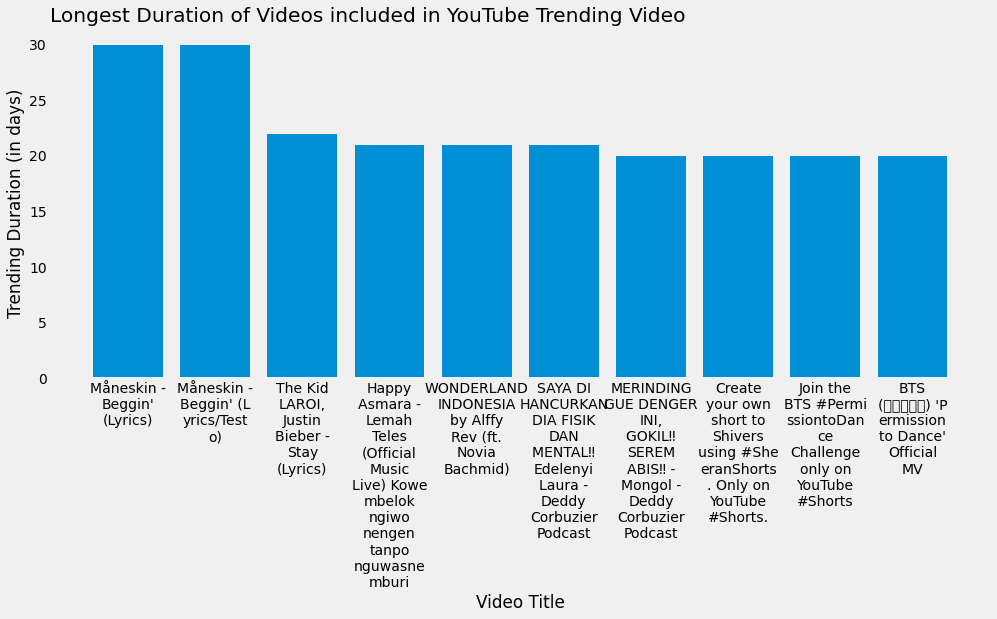

In [15]:
# Visualisasi data trending dengan chart bar

plt.figure(figsize=(15, 6))
plt.bar(
    trending_duration.title[:10].apply(lambda title: "\n".join(wrap(title, width=10))),
    trending_duration.trending_duration[:10]
)
plt.title("Longest Duration of Videos included in YouTube Trending Video", loc="left")
plt.xlabel("Video Title")
plt.ylabel("Trending Duration (in days)")
plt.grid(False)
plt.show()

<h2>Tips</h2>

Silakan eksplor lebih jauh lagi untuk durasi sebuah video bertahan dalam daftar trending dalam hal kategori video, channel, dan lainnya.

# Most Viewed, Liked, and Disliked Video

Metrik ini tentu sangat umum dan dijunjung tinggi oleh para kreator konten YouTube. Dengan metrik tersebut, kita juga bisa membuat YouTube Rewind 2021 versi sederhana kita sendiri.

In [16]:
trending_by_title = filtered_trending.groupby("title")
trending_rewind = trending_by_title[["view", "like", "dislike"]].agg(["min", "max", "mean", "sum"])
trending_rewind

view             \
                                                          min        max   
title                                                                      
"Awalnya Diserang Bertubi tubi" Lihatlah Bagaim...   101823.0   121044.0   
"BABY R" BIKIN GEMES !!! RAFATHAR CEMBURU, SEMU...  2280620.0  2637486.0   
"Emosi Rico Simanjutak" Saat Taisei Marukawa Be...    72434.0   116310.0   
"Grebek rumah harris vriza, dan percintaannya d...    68879.0   163773.0   
"Ini adalah IMPIAN bapa saya" - Tangisan Goh Li...   503651.0   822845.0   
...                                                       ...        ...   
🤟🏻aespa 'Savage' MV Reaction🤟🏻                      1011999.0  1885538.0   
🥰 New Gadgets & Versatile Utensils For Home # 2...   330156.0  7334655.0   
🥰 New Gadgets & Versatile Utensils For Home # 3...   278942.0  1212522.0   
🥰 New Gadgets & Versatile Utensils For Home # 3...   320084.0  1097903.0   
🩸괴담회에 어서오세요🩸: 첫 번째 이야기 | WELCOME TO NCT’S HORRO...  1423178.0  2966798.0   

                                                                              \
                                                            mean         sum   
title                                                                          
"Awalnya Diserang Bertubi tubi" Lihatlah Bagaim...  1.114335e+05    222867.0   
"BABY R" BIKIN GEMES !!! RAFATHAR CEMBURU, SEMU...  2.459053e+06   4918106.0   
"Emosi Rico Simanjutak" Saat Taisei Marukawa Be...  9.390625e+04    375625.0   
"Grebek rumah harris vriza, dan percintaannya d...  1.267565e+05    760539.0   
"Ini adalah IMPIAN bapa saya" - Tangisan Goh Li...  7.171452e+05   3585726.0   
...                                                          ...         ...   
🤟🏻aespa 'Savage' MV Reaction🤟🏻                      1.567651e+06  10973554.0   
🥰 New Gadgets & Versatile Utensils For Home # 2...  3.414214e+06  34142143.0   
🥰 New Gadgets & Versatile Utensils For Home # 3...  7.948737e+05   5564116.0   
🥰 New Gadgets & Versatile Utensils For Home # 3...  7.562497e+05   4537498.0   
🩸괴담회에 어서오세요🩸: 첫 번째 이야기 | WELCOME TO NCT’S HORRO...  2.629831e+06  36817634.0   

                                                        like            \
                                                         min       max   
title                                                                    
"Awalnya Diserang Bertubi tubi" Lihatlah Bagaim...    1336.0    1456.0   
"BABY R" BIKIN GEMES !!! RAFATHAR CEMBURU, SEMU...   93348.0  101207.0   
"Emosi Rico Simanjutak" Saat Taisei Marukawa Be...     990.0    1432.0   
"Grebek rumah harris vriza, dan percintaannya d...    5529.0    8714.0   
"Ini adalah IMPIAN bapa saya" - Tangisan Goh Li...    6952.0    9144.0   
...                                                      ...       ...   
🤟🏻aespa 'Savage' MV Reaction🤟🏻                      127578.0  186596.0   
🥰 New Gadgets & Versatile Utensils For Home # 2...    2822.0   58066.0   
🥰 New Gadgets & Versatile Utensils For Home # 3...    2790.0   10212.0   
🥰 New Gadgets & Versatile Utensils For Home # 3...    3025.0    8759.0   
🩸괴담회에 어서오세요🩸: 첫 번째 이야기 | WELCOME TO NCT’S HORRO...  316849.0  457809.0   

                                                                              \
                                                             mean        sum   
title                                                                          
"Awalnya Diserang Bertubi tubi" Lihatlah Bagaim...    1396.000000     2792.0   
"BABY R" BIKIN GEMES !!! RAFATHAR CEMBURU, SEMU...   97277.500000   194555.0   
"Emosi Rico Simanjutak" Saat Taisei Marukawa Be...    1228.500000     4914.0   
"Grebek rumah harris vriza, dan percintaannya d...    7486.833333    44921.0   
"Ini adalah IMPIAN bapa saya" - Tangisan Goh Li...    8436.200000    42181.0   
...                                                           ...        ...   
🤟🏻aespa 'Savage' MV Reaction🤟🏻                      165558.857143  1158912.0   
🥰 New Gadgets & Versatile Utensils

Jika kita lihat data di atas, ada beberapa video yang jumlah minimal dan maksimum <code>view, like,</code> maupun <code>dislike</code> yang berbeda. Ini bisa saja dikarenakan video tersebut yang bertahan beberapa hari dalam trending, seperti video <code>"Emosi Rico Simanjutak" Saat ... </code> yang dimulai dengan jumlah <code>view</code> <b>72.434</b> pada awal masuk trending dan pada hari terakhir dalam trending mencapai jumlah view <b>116.310</b>.



# Visualisasi 

Sekarang, mari kita lihat jumlah maksimal <code>view, like</code>, dan <code>dislike<code> dari video teratas masing-masing tersebut dan bandingkan dengan pada saat awal masuk trending.

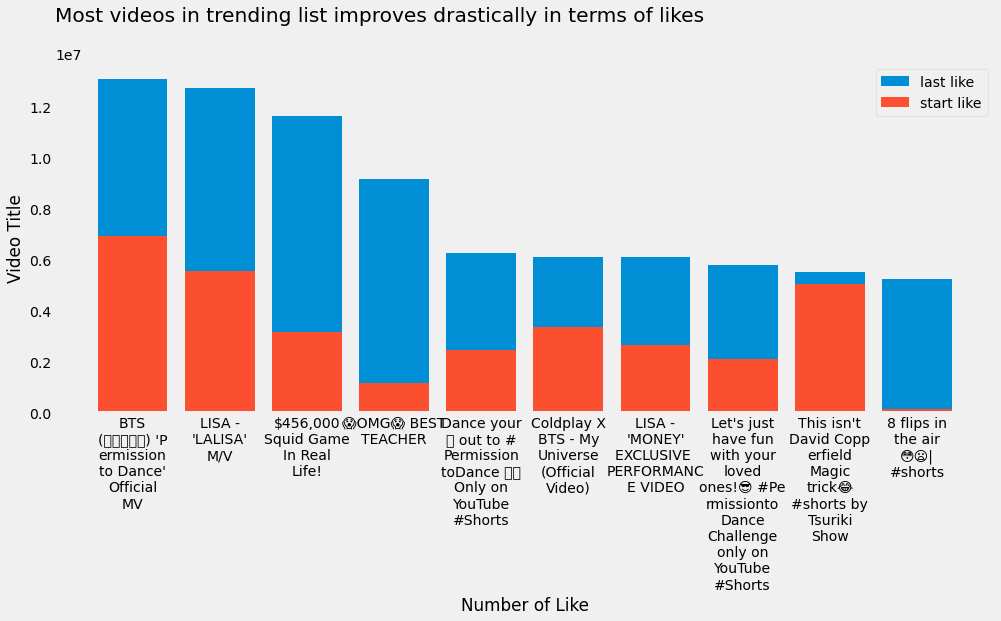

In [17]:
# Visualisasi Trending video teratas masing2

top_10_liked = trending_rewind["like"].sort_values("max", ascending=False).iloc[:10]

plt.figure(figsize=(15, 6))
plt.bar(
    top_10_liked.index.to_series().apply(lambda title: "\n".join(wrap(title, width=10))),
    top_10_liked["max"],
    label="last like"
)
plt.bar(
    top_10_liked.index.to_series().apply(lambda title: "\n".join(wrap(title, width=10))),
    top_10_liked["min"],
    label="start like"
)
plt.title("Most videos in trending list improves drastically in terms of likes", loc="left", y=1.1)
plt.xlabel("Number of Like")
plt.ylabel("Video Title")
plt.legend()
plt.grid(False)
plt.show()

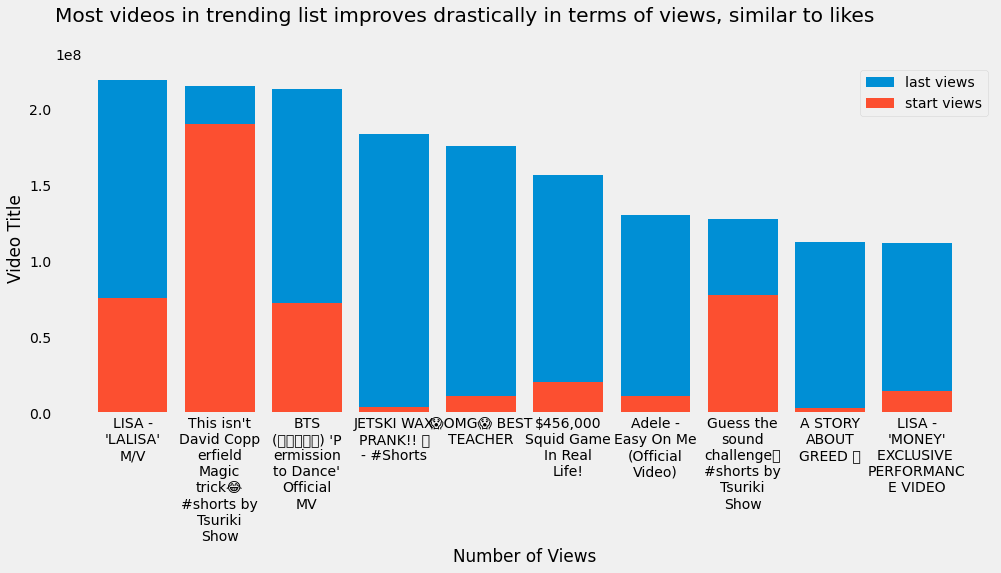

In [18]:
top_10_viewed = trending_rewind["view"].sort_values("max", ascending=False).iloc[:10]

plt.figure(figsize=(15, 6))
plt.bar(
    top_10_viewed.index.to_series().apply(lambda title: "\n".join(wrap(title, width=10))),
    top_10_viewed["max"],
    label="last views"
)
plt.bar(
    top_10_viewed.index.to_series().apply(lambda title: "\n".join(wrap(title, width=10))),
    top_10_viewed["min"],
    label="start views"
)
plt.title("Most videos in trending list improves drastically in terms of views, similar to likes", loc="left", y=1.1)
plt.xlabel("Number of Views")
plt.ylabel("Video Title")
plt.legend()
plt.grid(False)
plt.show()

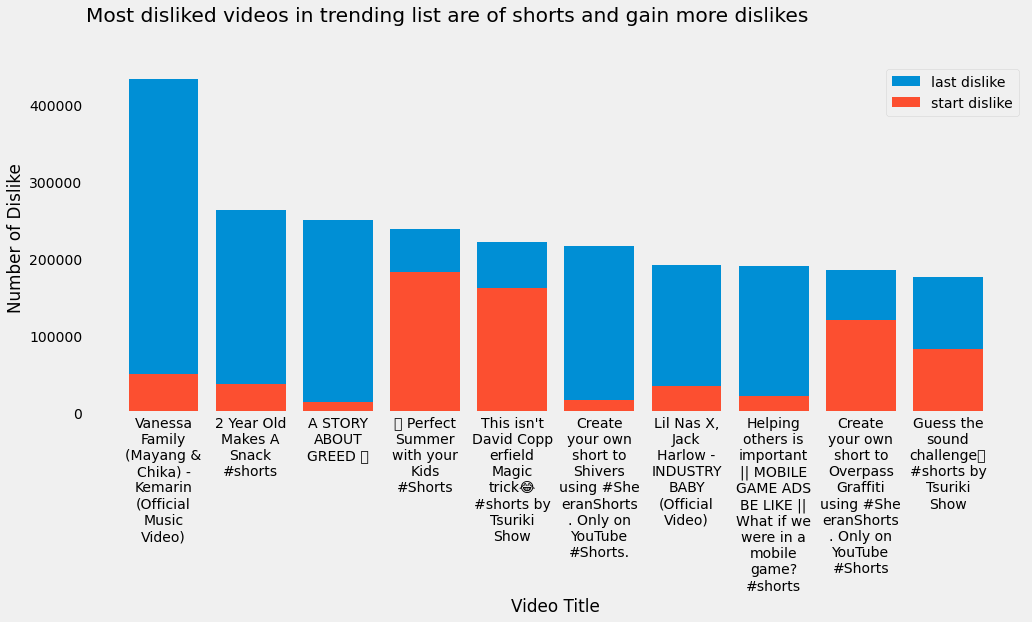

In [19]:
top_10_disliked = trending_rewind["dislike"].sort_values("max", ascending=False).iloc[:10]

plt.figure(figsize=(15, 6))
plt.bar(
    top_10_disliked.index.to_series().apply(lambda title: "\n".join(wrap(title, width=10))),
    top_10_disliked["max"],
    label="last dislike"
)
plt.bar(
    top_10_disliked.index.to_series().apply(lambda title: "\n".join(wrap(title, width=10))),
    top_10_disliked["min"],
    label="start dislike"
)
plt.title("Most disliked videos in trending list are of shorts and gain more dislikes", loc="left", y=1.1)
plt.ylabel("Number of Dislike")
plt.xlabel("Video Title")
plt.legend()
plt.grid(False)
plt.show()

<h1>Tips</h1>

Kamu bisa melakukan eksplorasi lebih jauh lagi, seperti:
<ul>
<li>most viewed, liked, and disliked channels</li>

<li>video age from published until it’s trending</li>

<li>dan lainnya</li>

# Data Preparation

Data judul dan deskripsi yang akan kita proses nantinya termasuk ke dalam unstructured data atau teks. Pemrosesan data teks ini termasuk ke dalam bidang NLP (Natural Language Processing)

# Language Detection

Setelah melakukan eksplorasi, sekarang saatnya kita menyiapkan data yang akan digunakan untuk mengklasifikaskan kategori video, yaitu <code>title dan description.</code>

jika belum memiliki silahkan install dulu dengan cara 

<code>pip install langdetect</code>

<h1>Attention</h1>
Kita hanya akan menggunakan video yang judul dan deskripsinya menggunakan bahasa Indonesia.

In [20]:
# Sebagai contoh, perhatikan sampel judul dan deskripsi video berikut.

sample = filtered_trending.sample(10, random_state=11)
sample[["title", "description"]]

,title,description
52988,Watford 1-2 Chelsea | Hakim Ziyech Scores Late...,Hakim Ziyech chose a good time to score his fi...
51897,アニメ「ジョジョの奇妙な冒険 ストーンオーシャン」OP映像,オープニングアニメーション：神風動画\n\n【OP音楽情報】\n曲名：「STONE OCEA...
24080,BTS - Permission to Dance Lyrics (Color Coded ...,All Rights Administered by BIGHIT MUSIC\n\n• A...
23683,ATEEZ JAPAN 1st SINGLE 'Dreamers' Music Video,◆RELEASE INFO\n2021年7月28日(水)発売\n\nATEEZ JAPAN ...
23304,Viral Puluhan Anggota Paspampres Datangi Polre...,TEMPO.CO - Sebuah video beredar di media sosia...
44713,Squid Game - Chosen One | Gacha Club | Ppg x R...,Squid Game - Chosen One | Gacha Club | Ppg x R...
31150,MARSHEL PASRAH JADI PASIEN CHIROPRACTIC BIMA A...,Talk show malam yang akan memberikan informasi...
23550,NGERI! Ratusan Ojol vs Debt Collector Bentroka...,Tanggal Tayang: 07/07/2021\n\nEmbrionya adalah...
51728,"Layangan Putus EP01A | Reza Rahadian, Putri Ma...","Yuk tonton full episodenya, GRATIS melalui app..."
30337,Highlights: Norwich 0-3 Liverpool | Salah sets...,"Watch the key action from Carrow Road, where D..."


In [21]:
# Merubah title dan descripsi video menjadi lowercase

sample["title_lang"] = sample.title.apply(lambda title: langdetect.detect(title.lower()))
sample["desc_lang"] = sample.description.apply(lambda desc: langdetect.detect(desc.lower()))

In [22]:
with pd.option_context("display.max_colwidth", 100):
    display(sample[["title", "title_lang", "description", "desc_lang"]])

,title,title_lang,description,desc_lang
52988,Watford 1-2 Chelsea | Hakim Ziyech Scores Late Winner To Keep Blues Top | Premier League Highlights,en,"Hakim Ziyech chose a good time to score his first Premier League goal of the season, netting a l...",en
51897,アニメ「ジョジョの奇妙な冒険 ストーンオーシャン」OP映像,ja,オープニングアニメーション：神風動画\n\n【OP音楽情報】\n曲名：「STONE OCEAN」\n歌：ichigo from 岸田教団&THE明星ロケッツ\n作詞：藤林聖子\n作曲：河田貴央...,ja
24080,BTS - Permission to Dance Lyrics (Color Coded Lyrics),en,All Rights Administered by BIGHIT MUSIC\n\n• Artist: BTS\n• Song ♫: Permission to Dance\n• Album...,en
23683,ATEEZ JAPAN 1st SINGLE 'Dreamers' Music Video,en,"◆RELEASE INFO\n2021年7月28日(水)発売\n\nATEEZ JAPAN 1st SINGLE「Dreamers」\n【TYPE-A】CD＋DVD ￥2,500(Tax in...",ja
23304,"Viral Puluhan Anggota Paspampres Datangi Polres Jakarta Barat, Tak Terima Ada Anggota Polisi Arogan",id,TEMPO.CO - Sebuah video beredar di media sosial menampilkan keributan seorang anggota Paspampres...,id
44713,Squid Game - Chosen One | Gacha Club | Ppg x Rrb Gacha Life,en,Squid Game - Chosen One | Gacha Club | Ppg x Rrb Gacha Life\n\n❤️Welcome to Gacha Fans' Homepage...,en
31150,MARSHEL PASRAH JADI PASIEN CHIROPRACTIC BIMA ARYO - Tonight Show Premiere,en,"Talk show malam yang akan memberikan informasi dan hiburan, bersama Vincent, Desta Hesti dan En...",id
23550,"NGERI! Ratusan Ojol vs Debt Collector Bentrokan di Mangga Besar, Jakpus #SIP 07/07",id,Tanggal Tayang: 07/07/2021\n\nEmbrionya adalah program Seputar Jakarta yang pertama mengudara pa...,id
51728,"Layangan Putus EP01A | Reza Rahadian, Putri Marino | WeTV Original",id,"Yuk tonton full episodenya, GRATIS melalui apps WeTV disini https://bit.ly/2ZqNtOZ !\nTayang set...",id
30337,Highlights: Norwich 0-3 Liverpool | Salah sets new opening day record,en,"Watch the key action from Carrow Road, where Diogo Jota, Roberto Firmino & Mo Salah gave the Red...",en


<h2>Note</h2>

Perhatikan bahwa sebelum langdetect.detect, title dan deskripsi dijadikan lowercase. Ini dilakukan supaya langdetect dapat mendeteksi bahasa secara maksimal.

Ada beberapa kasus yang mungkin terjadi untuk deteksi bahasa pada judul dan deskripsi di atas:
<ul>
<li>Judul berbahasa Indonesia, sedangkan deskripsi dideteksi sebagai bahasa asing (yang mungkin seharusnya bahasa Indonesia)</li>

<li>Deksripsi dideteksi sebagai bahasa Indonesia, sedangkan judul berbahasa asing (yang mungkin seharusnya bahasa Indonesia)</li>

<li>Baik judul atau deskripsi dideteksi sebagai bahasa asing, yang seharusnya salah satu atau keduanya berbahasa Indonesia</li>
</ul>

Untuk kemungkinan ketiga, kita tidak akan menggunakan video yang judul dan deskripsinya dideteksi sebagai bahasa asing, meskipun seharusnya salah deteksi. Sekarang, mari kita deteksi bahasa untuk semua video dalam <code>filtered_trending.</code>



In [23]:
# Pertama, kita akan buat fungsi yang akan mendeteksi bahasa dari sebuah teks sebagai berikut.

def detect_language(text):
    """Detect language of the `text`."""
    try:
        lang = langdetect.detect(text)
        return lang
    except:
        return


In [24]:
def detect_language(text):
    """Detect language of the `text`."""
    try:
        lang = langdetect.detect(text)
        return lang
    except:
        return

In [25]:
filtered_trending["title_lang"] = filtered_trending["title"].apply(detect_language)
filtered_trending["desc_lang"] = filtered_trending["description"].apply(detect_language)

In [26]:
filtered_trending[["title", "title_lang", "description", "desc_lang"]]

,title,title_lang,description,desc_lang
21322,NCT DREAM 엔시티 드림 'Hello Future' MV,it,"NCT DREAM's 1st Album Repackage ""Hello Future""...",en
21323,PART 3 // SUTRISNO DAN ENDANG BAHAGIA,de,Find me on sosial media :\n\nInstagram : https...,en
21324,This isn't David Copperfield Magic trick😂 #sho...,en,Thank you for watching.\nSubscribe to Tsuriki ...,en
21325,Rizky Billar - Pemimpinmu | Official Music Video,it,Rizky Billar - Pemimpinmu | Official Music Vid...,id
21326,Ini Pengakuan Pengemudi Pajero usai Rusak dan ...,id,Polisi menangkap pengemudi SUV yang merusak da...,id
...,...,...,...,...
57654,Denny Caknan feat. Happy Asmara - Tak Kan Berp...,id,Judul: Tak Kan Berpisah\nPencipta Lagu: Rijal ...,id
57655,Sunset cover - Wildfire,da,Wildfire by Cautious Clay\n\nFollow Rosé:\nIns...,en
57656,PUSH GLORY KEJAR SUPREME ASSASIN,de,DOUBLE LIVE DI BOOYAH : https://booyah.live/ch...,id
57657,JENIS KELAMIN ANAK ENDANG DAN SUTRISNO,de,Find me on sosial media :\n\nInstagram : https...,en


Setelah kita selesai mendeteksi bahasa pada <code>title dan description</code>, langkah selanjutnya adalah membuang data yang <code>title</code> atau <code>description</code> bukan <code>id</code>, yaitu tidak berbahasa Indonesia.

In [27]:
indo_trending = filtered_trending.loc[
    (filtered_trending.title_lang == "id") | (filtered_trending.desc_lang == "id")
]

with pd.option_context("display.max_columns", None):
    display(indo_trending.sample(10))

,video_id,publish_time,channel_id,title,description,thumbnail_url,thumbnail_width,thumbnail_height,channel_name,tags,category_id,live_status,local_title,local_description,duration,dimension,definition,caption,license_status,allowed_region,blocked_region,view,like,dislike,favorite,comment,trending_time,title_lang,desc_lang
37472,NaN,2021-09-15 15:11:02+00:00,UCM3SMB1jINy_NxH1O01z5gA,[2021] Free Fire Master League Season IV Divis...,"Hi Survivors!\n\nDi Matchday 9 kali ini, akan ...",NaN,NaN,NaN,Garena Free Fire Indonesia,NaN,20,none,[2021] Free Fire Master League Season IV Divis...,"Hi Survivors!\n\nDi Matchday 9 kali ini, akan ...",PT3H11M10S,2d,hd,False,False,NaN,NaN,433260.0,14771.0,390.0,0,218.0,2021-09-19 06:00:55.571473+00:00,en,id
47587,NaN,2021-11-04 14:27:17+00:00,UCPp7ZTRk9vzo-wFP8mQ3uFA,[BAHASA INDONESIA] ONE Esports MPL Invitationa...,Sekarang atau tidak sama sekali. Jangan lewatk...,NaN,NaN,NaN,ONE Esports,"['MPLI', 'MPL', 'MLBB', 'Mobile Legends Bang B...",20,none,[BAHASA INDONESIA] ONE Esports MPL Invitationa...,Sekarang atau tidak sama sekali. Jangan lewatk...,PT8H55M42S,2d,hd,False,False,NaN,NaN,2901108.0,31808.0,774.0,0,7.0,2021-11-09 06:01:34.631721+00:00,en,id
56200,AcU2hVjWl1Y,2021-12-21 14:11:11+00:00,UCv6pNBPK9wlPsKhEwUKUocw,RRQ MIKA VS ONIC ZENITH | WOMAN STAR LEAGUE ...,Bagi kalian yang belum pindah nonton ke BOOYAH...,https://i.ytimg.com/vi/AcU2hVjWl1Y/hqdefault.jpg,480.0,360.0,Woman Star League,"['wsl', 'woman star league', 'mobile legends',...",20,none,RRQ MIKA VS ONIC ZENITH | WOMAN STAR LEAGUE ...,Bagi kalian yang belum pindah nonton ke BOOYAH...,PT6H14M,2d,hd,False,True,NaN,NaN,464021.0,6049.0,NaN,0,11.0,2021-12-23 06:01:04.072757+00:00,de,id
24217,NaN,2021-07-13 17:26:48+00:00,UCzTsWuCdVP_vehWyGwPcS3Q,IKATAN CINTA - Gak Punya Cara Lain!! Nino Diam...,"Saksikan Ikatan Cinta full episode, klik https...",NaN,NaN,NaN,RCTI - LAYAR DRAMA INDONESIA,"['Ikatan Cinta', 'Ikatan Cinta Hari ini', 'Ika...",24,none,IKATAN CINTA - Gak Punya Cara Lain!! Nino Diam...,"Saksikan Ikatan Cinta full episode, klik https...",PT15M6S,2d,hd,False,True,NaN,NaN,1140208.0,10590.0,767.0,0,877.0,2021-07-15 06:01:12.512614+00:00,id,id
40287,NaN,2021-09-25 02:00:11+00:00,UCmiJjv8BbzLahKpsfkQaBnA,Arief - Rembulan Malam (Official Music Video),Official Music Video Arief Rembulan Malam\n\nM...,NaN,NaN,NaN,Arief Putra,"['arief', 'arief official', 'arief terbaru 202...",10,none,Arief - Rembulan Malam (Official Music Video),Official Music Video Arief Rembulan Malam\n\nM...,PT4M48S,2d,hd,True,True,NaN,NaN,581356.0,14824.0,335.0,0,1555.0,2021-10-03 06:00:46.527787+00:00,ro,id
30449,NaN,2021-07-31 06:26:34+00:00,UCplJmnOkqH9tisNhkF6hWEA,Drama Sahabat Masa Kecil [FULL EPISODE] #sptra...,Drama Sahabat Masa Kecil [FULL EPISODE] #sptra...,NaN,NaN,NaN,Sptrakori_Official,"['meme', 'sptrakori official', 'sptrakori', 't...",22,none,Drama Sahabat Masa Kecil [FULL EPISODE] #sptra...,Drama Sahabat Masa Kecil [FULL EPISODE] #sptra...,PT46M45S,2d,hd,False,True,NaN,NaN,4897311.0,136510.0,5475.0,0,10771.0,2021-08-15 06:00:52.338853+00:00,id,id
25366,NaN,2021-07-14 10:00:21+00:00,UCGXnDxirLuSrIHwQXWxRzeg,KIAT KECANTIKAN SERU UNTUK ANAK SEKOLAH || Tip...,Kiat kecantikan dan makeup ini akan membuat ka...,NaN,NaN,NaN,123 GO LIKE! Indonesian,"['123 go', '123 GO!', '123 GO! Like', '123 GO!...",24,none,KIAT KECANTIKAN SERU UNTUK ANAK SEKOLAH || Tip...,Kiat kecantikan dan makeup ini akan membuat ka...,PT30M53S,2d,hd,False,True,NaN,NaN,903040.0,8196.0,948.0,0,446.0,2021-07-21 06:01:23.250611+00:00,id,id
51359,NaN,2021-11-19 11:30:10+00:00,UCItetAba7TUucRmL8a3qrgA,Zidan Ft Tri Suaka - Sia Sia Berjuang (Officia...,#ZinidinZidan #TriSuaka #SiaSiaBerjuang\nZidan...,NaN,NaN,NaN,TriAngle,"['triangle', 'tri suaka', 'nabila suaka', 'jan...",10,none,Zidan Ft Tri Suaka - Sia Sia Berjuang (Officia...,#ZinidinZidan #TriSuaka #SiaSiaBerjuang\nZidan...,PT5M13S,2d,hd,True,True,NaN,NaN,3729721.0,140780.0,2715.0,0,9656.0,2021-11-29 06:01:42.842536+00:00,id,id
50186,NaN,2021-11-19

# Feature Extraction

Selanjutnya, kita akan membuang semua fitur/kolom yang tidak diperlukan. Dalam hal ini, kita hanya akan memerlukan <code>title, descrption,</code> dan <code>category_id</code>. Sehingga, kolom lainnya akan dibuang.

In [28]:
data = indo_trending[["title", "description", "category_id"]].reset_index(drop=True)
data

,title,description,category_id
0,Rizky Billar - Pemimpinmu | Official Music Video,Rizky Billar - Pemimpinmu | Official Music Vid...,10
1,Ini Pengakuan Pengemudi Pajero usai Rusak dan ...,Polisi menangkap pengemudi SUV yang merusak da...,25
2,Aksi Demo Tolak Kedatangan Jokowi di Kendari B...,Tanggal Tayang: 30/06/2021\n\nProgram berita h...,25
3,"PERTAMA KALI LIAT SAPI SEGEDE GINI, DINAIKIN D...",Assalamualaikum gaeess..! sudah nonton video s...,15
4,PODKESMAS SAMPAI GA NYAMAN DIBAHAS DISINI - To...,Talk show malam yang akan memberikan informasi...,24
...,...,...,...
20558,Aku Hamil Bayi Squid Game - Kiat Keren Untuk B...,Kita gak bisa milih mau lahir jadi orang TAJIR...,22
20559,SEDIH!!! KOLAB TERAKHIR FUJI & OMAY NYOSOR SAM...,"Hi… sebelum lanjut nyantap sambal julid, Kalia...",22
20560,[ID] PMGC 2021 League East | Finals Day 1 | PU...,"""20 Tim terbaik dari East akan bertarung habis...",20
20561,Denny Caknan feat. Happy Asmara - Tak Kan Berp...,Judul: Tak Kan Berpisah\nPencipta Lagu: Rijal ...,10


# Duplicates

Jika kita perhatikan secara teliti, kita akan temukan bahwa ada beberapa <code>title</code> ataupun <code>desription</code> yang duplikat. Hal in dikarenakan adanya kemungkinan sebuah video masuk dalam daftar trending pada hari yang berbeda. Untuk alasan fairness, kita akan membuang beberapa duplikat tersebut.

In [29]:
data.drop_duplicates(subset="title", inplace=True)

In [30]:
data.reset_index(drop=True, inplace=True)
data.shape

(4230, 3)

Setelah membuang beberapa duplikat, hanya tersisa 4230 baris data saja yang akan kita gunakan pada fase modeling.

# Feature Engineering

Kita tahu bahwa biasanya kreator konten suka menggunakan emoji di judul ataupun deskripsi video mereka. Emoji ini mungkin bisa menggambarkan judul dan deskripsi. Oleh karena itu, kita akan coba mengubah emoji tersebut ke dalam bentuk teks menggunakan library <code>emoji.</code>

Silakan install terlebih dahulu library <code>emoji</code> dengan perintah berikut.

Sebelum itu, mari kita ada berapa judul yang menggunakan emoji di dalamnya.

In [31]:
list_emoji = [e for e in emoji.UNICODE_EMOJI.get("en")]

count = 0
for em in list_emoji:
    for title in data.title:
        if em in title:
            count += 1
print("How many titles use emoji?", count)

How many titles use emoji? 591


Ternyata ada $591$ video yang judul nya menggunakan emoji. Kita akan buat fungsi untuk menerjemahkan emoji di dalam judul sebagai berikut.

In [32]:
def demojize(text):
    for em in list_emoji:
        if em in text:
            em_text = emoji.demojize(em)
            text = text.replace(em, " " + em_text + " ")
    return text

In [33]:
def demojize(text):
    for em in list_emoji:
        if em in text:
            em_text = emoji.demojize(em)
            text = text.replace(em, " " + em_text + " ")
    return text

In [34]:
data["title_emoji"] = data.title.apply(demojize)

Mari kita lihat beberapa sampel judul yang menggunakan emoji dan bagaimana bentuk representasi teksnya.

In [ ]:
title_with_emoji_idx = [
    idx for idx in range(len(data.title))
    for em in list_emoji
    if em in data.loc[idx, "title"]
]

In [ ]:
with pd.option_context("display.max_colwidth", 100):
    display(data.loc[title_with_emoji_idx])

Karena kita sudah mendapatkan representasi emoji pada kolom <code>title_emoji</code>, kita tidak memerlukan kolom <code>title</code> lagi. Sehingga, kita bisa buang kolom tersebut.

In [35]:
data.drop(columns="title", inplace=True)

Selanjutnya, kita akan melakukan hal yang sama pada kolom <code>description</code> untuk kasus emoji.

<h1>Eksplorasi</h1>
Ada berapa video yang deskripsinya menggunakan emoji?

In [36]:
desc_with_emoji_idx = [
    idx for idx in range(len(data.description))
    for em in list_emoji
    if em in data.loc[idx, "description"]
]

data["desc_emoji"] = data.description.apply(demojize)

with pd.option_context("display.max_colwidth", 100):
    display(data.loc[desc_with_emoji_idx])

,description,category_id,title_emoji,desc_emoji
0,Rizky Billar - Pemimpinmu | Official Music Video\n\nSurprise Untuk Dede Lesti :\nhttps://youtu.b...,10,Rizky Billar - Pemimpinmu | Official Music Video,Rizky Billar - Pemimpinmu | Official Music Video\n\nSurprise Untuk Dede Lesti :\nhttps://youtu.b...
10,"Title: Sempurnakan Hariku \nArtist: Rey Mbayang\nComposser: Rey Mbayang, Trakast\nMusic Arranger...",10,Rey Mbayang - Sempurnakan Hariku (Official Music Video),"Title: Sempurnakan Hariku \nArtist: Rey Mbayang\nComposser: Rey Mbayang, Trakast\nMusic Arranger..."
11,Title: Apa Kabar Mantan\nArtist: Yeni Inka\nSongwriter: Yonanda NDX\n\nFollow juga kita disini y...,10,Yeni Inka - Apa Kabar Mantan (Official Music Video ANEKA SAFARI) | JOOX ORIGINAL,Title: Apa Kabar Mantan\nArtist: Yeni Inka\nSongwriter: Yonanda NDX\n\nFollow juga kita disini y...
11,Title: Apa Kabar Mantan\nArtist: Yeni Inka\nSongwriter: Yonanda NDX\n\nFollow juga kita disini y...,10,Yeni Inka - Apa Kabar Mantan (Official Music Video ANEKA SAFARI) | JOOX ORIGINAL,Title: Apa Kabar Mantan\nArtist: Yeni Inka\nSongwriter: Yonanda NDX\n\nFollow juga kita disini y...
13,#ByoodeJanganCobaCoba #Byoode #MusicVideo #Girlband #Dangdut\n\nDengerin lagu Byoode - Jangan Co...,10,Byoode - Jangan Coba Coba | Official Music Video,#ByoodeJanganCobaCoba #Byoode #MusicVideo #Girlband #Dangdut\n\nDengerin lagu Byoode - Jangan Co...
...,...,...,...,...
4203,WELCOME DESEMBER!\nTHANKYOU UNTUK SEMUANYA SELAMA INI!\n.\nGw mau bagi2 200 Juta untuk 100 orang...,20,MODE MARSHA x MODE OURA x MODE DONKEY,WELCOME DESEMBER!\nTHANKYOU UNTUK SEMUANYA SELAMA INI!\n.\nGw mau bagi2 200 Juta untuk 100 orang...
4210,Di penghujung tahun 2021 sebuah kejutan datang dari duo viral Nuca dan Mahalini. Siapa yang tida...,10,NUCA & MAHALINI - JANJI KITA (OFFICIAL MUSIC VIDEO),Di penghujung tahun 2021 sebuah kejutan datang dari duo viral Nuca dan Mahalini. Siapa yang tida...
4212,Pernah gak sih kalian kesiangan ke acara suatu tempat terus the only place untuk make up biar he...,24,CARA MAKE UP CEPET DI MOBIL | #Shorts,Pernah gak sih kalian kesiangan ke acara suatu tempat terus the only place untuk make up biar he...
4218,"Abdurachman, Ikbal dan Gan Gan Maju Sebagai Peserta Selanjutnya! Ikbal Yang Membawakan Lagu 'Tik...",10,"SUARA UNIK GAN GAN & IKBAL, SUKSES DAPATKAN 5 YES DARI JUDGES | X FACTOR INDONESIA 2021","Abdurachman, Ikbal dan Gan Gan Maju Sebagai Peserta Selanjutnya! Ikbal Yang Membawakan Lagu 'Tik..."


Kita juga bisa buang kolom <code>description</code> karena kita tidak membutuhkannya lagi.

In [37]:
data.drop(columns="description", inplace=True)

Selanjutnya, kita akan gabungkan <code>title_emoji</code> dan <code>desc_emoji</code> menjadi satu teks yang panjang ke dalam kolom <code>all_text</code>. Kolom ini yang selanjutnya akan kita gunakan untuk membentuk matriks TF-IDF.

In [38]:
data["all_text"] = data["title_emoji"] + " " + data["desc_emoji"]

# Text Processing 

Untuk membentuk matrik TF-IDF, kita akan gunakan bantuan <code>scikit-learn</code> berdasarkan data training.

<h1>Note</h1>
Kita akan bagi data terlebih dahulu menjadi training dan development.

In [39]:
# data split
X_train, X_dev, y_train, y_dev = train_test_split(
    data["all_text"], data["category_id"],
    test_size=.2,
    stratify=data["category_id"],
    random_state=11
)
training_size = X_train.shape[0]
dev_size = X_dev.shape[0]

print(f"{training_size = }.. {dev_size = }")

# define vectorizer
vectorizer = TfidfVectorizer(
    min_df=.015,
    max_df=.7,
    ngram_range=(1, 1),
)

# generate tf-idf matrix
train_tfidf = vectorizer.fit_transform(X_train)
dev_tfidf = vectorizer.transform(X_dev)
print("Got train tf-idf with shape:", train_tfidf.shape)
print("Got dev tf-idf with shape:", dev_tfidf.shape)

# convert to dataframe
train_tfidf = pd.DataFrame(train_tfidf.toarray(), columns=vectorizer.get_feature_names_out())
dev_tfidf = pd.DataFrame(dev_tfidf.toarray(), columns=vectorizer.get_feature_names_out())

training_size = 3384.. dev_size = 846
Got train tf-idf with shape: (3384, 947)
Got dev tf-idf with shape: (846, 947)


In [40]:
with pd.option_context("display.max_columns", 100):
    display(train_tfidf.sample(5))

,00,000,01,02,03,04,05,06,07,08,09,10,11,12,123,13,14,15,16,17,18,19,1dvz1au,1gxqz9s,1st,20,2020,2021,21,22,23,24,25,26,28,2oukyag,2yfofxp,30,31,3ws0f48,40,45,50,62,about,acara,account,ada,adalah,adanya,...,under,untuk,untukmu,up,update,upload,us,usai,user,utama,utm_medium,vanessa,via,video,videonya,videos,vidio,viral,vocal,vs,vt,wa,waktu,wanita,warga,watch,watching,web,website,wes,whatsapp,wib,with,withyoutube,wong,www,ya,yaa,yah,yaitu,yang,yen,yeni,yeniinka,yg,you,your,youtu,youtube,yuk
3175,0.0,0.0,0.0,0.0,0.064752,0.0,0.068496,0.0,0.057319,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.058823,0.0,0.0,0.0,0.0,0.097754,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.067515,0.0,0.0,0.0,0.0,0.045347,0.0,0.0,0.0,0.0,0.067515,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.148044,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.263325,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.175399,0.035654,0.000000,0.0,0.0,0.117234,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.045982
2751,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.085524,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.206065,0.0,0.0,0.0,0.0,0.067551,0.000000,0.000000,0.0,0.0,0.067725,0.0,0.0,0.0,0.0,0.171673,0.0,0.0,0.000000,0.000000
1159,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.071284,0.000000,0.000000,0.0,0.0,0.071468,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.172615,0.000000
668,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.086666,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.126245,0.086666,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.159971,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.074786,0.045606,0.000000,0.0,0.0,0.049986,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
1539,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.081166,0.000000,0.075024,0.0,0.0,0.054250,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.032757,0.000000


# Modeling

Setelah mempersiapkan data untuk training, sekarang saatnya kita lakukan training menggunakan beberapa model. Model yang akan kita coba untuk mengklasifikasi kategori video YouTube seperti:
<ul>
<li>Logistic Regression</li>
<li>Naive Bayes</li>
<li>SVM</li>
<li>Decision Tree</li>
<li>Random Forest</li>
    </ul>

# Model Training & Evaluation

Pertama, mari kita definisikan beberapa model tersebut dan menggunakan default hyperparameter dari <code>scikit-learn</code> terlebih dahulu.

In [41]:
dict_models = {
    "logistic_regression": LogisticRegression(),
    "naive_bayes": MultinomialNB(),
    "svm": LinearSVC(random_state=11),
    "decision_tree": DecisionTreeClassifier(random_state=11),
    "random_forest": RandomForestClassifier(random_state=11)
}

In [42]:
for model in dict_models.values():
    print(f"-- {model.__class__.__name__} --")
    model.fit(train_tfidf, y_train)
    y_pred = model.predict(dev_tfidf)
    print("Reports on dev set:", classification_report(y_dev, y_pred), sep="\n")

-- LogisticRegression --
Reports on dev set:
              precision    recall  f1-score   support

           1       0.90      0.38      0.53        24
           2       1.00      0.73      0.84        22
          10       0.91      0.96      0.93       162
          15       1.00      0.88      0.93         8
          17       1.00      0.47      0.64        19
          19       1.00      0.40      0.57         5
          20       0.94      0.87      0.90        67
          22       0.75      0.62      0.68        81
          23       0.96      0.68      0.80        38
          24       0.74      0.90      0.81       263
          25       0.84      0.95      0.89       111
          26       0.86      0.33      0.48        18
          27       1.00      0.56      0.71         9
          28       1.00      0.75      0.86         8
          29       1.00      1.00      1.00        11

    accuracy                           0.83       846
   macro avg       0.93      0.70  

# Hyperparameter Tuning

Dari 5 model tersebut, 2 model yang paling bagus akurasinya adalah <code>LinearSVC</code> dan <code>RandomForestClassifier</code>. Oleh karena itu, kita akan coba melakukan hyperparameter tuning untuk kedua model tersebut, dengan harapan performa model akan semakin bagus. Kita akan menggunakan grid search untuk menentukan <b><i>hyperparameter</i></b> yang paling optimal.

# LinearSVC

In [43]:
svm_grid_search = GridSearchCV(
    dict_models["svm"],
    {"C": (10, 1, .1, .05, .01)},
)

svm_grid_search.fit(train_tfidf, y_train)
svm_pred_dev = svm_grid_search.predict(dev_tfidf)
print("Reports on train set:",
      classification_report(
          y_train,
          svm_grid_search.predict(train_tfidf)
      ), sep="\n")
print("Reports on dev set:", classification_report(y_dev, svm_pred_dev), sep="\n")

Reports on train set:
              precision    recall  f1-score   support

           1       0.99      0.94      0.96        95
           2       0.99      1.00      0.99        88
          10       0.96      0.99      0.97       649
          15       1.00      1.00      1.00        30
          17       0.94      0.99      0.96        75
          19       1.00      0.95      0.98        21
          20       0.98      0.97      0.98       268
          22       0.97      0.90      0.93       324
          23       0.97      0.97      0.97       151
          24       0.97      0.95      0.96      1055
          25       0.96      1.00      0.98       443
          26       0.92      0.94      0.93        71
          27       0.97      0.97      0.97        37
          28       1.00      1.00      1.00        30
          29       1.00      0.98      0.99        47

    accuracy                           0.97      3384
   macro avg       0.97      0.97      0.97      3384
weig

In [44]:
svm_grid_search.best_params_

{'C': 1}

# RandomForestClassifier

In [45]:
random_forest_grid_search = GridSearchCV(
    dict_models["random_forest"],
    {
        "n_estimators": (10, 20, 25, 50, 75, 100, 125),
        "max_depth": (5, 10, 25, 50),
    }
)

random_forest_grid_search.fit(train_tfidf, y_train)
random_forest_pred = random_forest_grid_search.predict(dev_tfidf)
print("Reports on train set:",
      classification_report(
          y_train,
          random_forest_grid_search.predict(train_tfidf)
      ),
      sep="\n"
)
print("Reports on dev set:", classification_report(y_dev, random_forest_pred), sep="\n")

Reports on train set:
              precision    recall  f1-score   support

           1       1.00      0.97      0.98        95
           2       1.00      0.95      0.98        88
          10       1.00      1.00      1.00       649
          15       1.00      0.93      0.97        30
          17       0.97      0.97      0.97        75
          19       1.00      0.86      0.92        21
          20       1.00      0.99      1.00       268
          22       1.00      0.98      0.99       324
          23       1.00      0.99      0.99       151
          24       0.97      1.00      0.99      1055
          25       1.00      1.00      1.00       443
          26       1.00      0.99      0.99        71
          27       1.00      1.00      1.00        37
          28       1.00      0.97      0.98        30
          29       1.00      0.98      0.99        47

    accuracy                           0.99      3384
   macro avg       1.00      0.97      0.98      3384
weig

In [46]:
random_forest_grid_search.best_params_

{'max_depth': 50, 'n_estimators': 100}

Dari sini, dapat disimpulkan bahwa model <b>Random Forest</b>, meskipun kedua model tersebut overfit, memiliki performa yang paling bagus pada data development. Sehingga, kita akan gunakan model tersebut untuk memprediksi kategori video lainnya.

# Save Model

Untuk keperluan prediksi, kita harus menyimpan model yang sudah kita latih sehingga dapat digunakan oleh pengguna, baik itu melalui deployment atau riset. Kita bisa gunakan <code>joblib</code> untuk menyimpan model <i>random forest</i> yang sudah kita latih tadi.

Tapi sebelum itu, kita juga harus simpan langkah-langkah pemrosesan teks TF-IDF ke dalam model. Oleh karena itu, kita akan buat sebuah model pipeline menggunakan <code>sklearn.pipeline.Pipeline</code>

In [47]:
model = Pipeline([
    ("vectorizer", TfidfVectorizer(
        min_df=.015,
        max_df=.7,
        ngram_range=(1, 1),
    )),
    ("model", RandomForestClassifier(
        max_depth=50,
        n_estimators=75,
        random_state=11
    ))
])

# training
model.fit(X_train, y_train)

pred = model.predict(X_dev)
print("Reports on train set:",
      classification_report(
          y_train,
          model.predict(X_train)
      ),
      sep="\n"
)
print("Reports on dev set:", classification_report(y_dev, pred), sep="\n")

Reports on train set:
              precision    recall  f1-score   support

           1       1.00      0.97      0.98        95
           2       1.00      0.95      0.98        88
          10       1.00      1.00      1.00       649
          15       1.00      0.93      0.97        30
          17       0.97      0.97      0.97        75
          19       1.00      0.90      0.95        21
          20       1.00      0.99      1.00       268
          22       1.00      0.98      0.99       324
          23       1.00      0.99      0.99       151
          24       0.97      1.00      0.99      1055
          25       1.00      1.00      1.00       443
          26       1.00      0.99      0.99        71
          27       1.00      1.00      1.00        37
          28       1.00      1.00      1.00        30
          29       1.00      0.98      0.99        47

    accuracy                           0.99      3384
   macro avg       1.00      0.98      0.99      3384
weig

In [48]:
joblib.dump(model, "D:/PTA 2016-2017/Modul/dataset/modelyt.joblib")

['D:/PTA 2016-2017/Modul/dataset/modelyt.joblib']

Untuk mengecek apakah model benar-benar sudah tersimpan, kita akan <code>load</code> modelnya dan gunakan untuk memprediksi data <code>development</code> yang harusnya memiliki laporan klasifikasi yang sama pada laporan sebelumnya.

In [50]:
model = joblib.load("D:/PTA 2016-2017/Modul/dataset/modelyt.joblib")
print(model.get_params())

{'memory': None, 'steps': [('vectorizer', TfidfVectorizer(max_df=0.7, min_df=0.015)), ('model', RandomForestClassifier(max_depth=50, n_estimators=75, random_state=11))], 'verbose': False, 'vectorizer': TfidfVectorizer(max_df=0.7, min_df=0.015), 'model': RandomForestClassifier(max_depth=50, n_estimators=75, random_state=11), 'vectorizer__analyzer': 'word', 'vectorizer__binary': False, 'vectorizer__decode_error': 'strict', 'vectorizer__dtype': <class 'numpy.float64'>, 'vectorizer__encoding': 'utf-8', 'vectorizer__input': 'content', 'vectorizer__lowercase': True, 'vectorizer__max_df': 0.7, 'vectorizer__max_features': None, 'vectorizer__min_df': 0.015, 'vectorizer__ngram_range': (1, 1), 'vectorizer__norm': 'l2', 'vectorizer__preprocessor': None, 'vectorizer__smooth_idf': True, 'vectorizer__stop_words': None, 'vectorizer__strip_accents': None, 'vectorizer__sublinear_tf': False, 'vectorizer__token_pattern': '(?u)\\b\\w\\w+\\b', 'vectorizer__tokenizer': None, 'vectorizer__use_idf': True, 'vec

In [51]:
preds = model.predict(X_dev)
print(classification_report(y_dev, preds))

              precision    recall  f1-score   support

           1       1.00      0.58      0.74        24
           2       1.00      0.86      0.93        22
          10       0.94      0.96      0.95       162
          15       1.00      0.88      0.93         8
          17       0.91      0.53      0.67        19
          19       1.00      0.60      0.75         5
          20       0.92      0.91      0.92        67
          22       0.97      0.69      0.81        81
          23       0.97      0.82      0.89        38
          24       0.80      0.92      0.86       263
          25       0.84      0.98      0.91       111
          26       0.81      0.72      0.76        18
          27       1.00      0.67      0.80         9
          28       1.00      0.62      0.77         8
          29       1.00      1.00      1.00        11

    accuracy                           0.88       846
   macro avg       0.94      0.78      0.84       846
weighted avg       0.89   